# Business background
## Analysis purpose
-Analyze the reasons for bad reviews and give improvement plans;

-Repeated delivery man defaults to the same rider;

-The same delivery man may have bad reviews on different sites

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import re

# data visualization
import cufflinks as cf
cf.set_config_file(offline=True)

import pandas_profiling as pp # Plot 
import plotly.express as px
from plotly import graph_objs as go

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 
#px.scatter(gapminder2007, x='gdpPercap', y='lifeExp')

# Data understanding

In [2]:
path = '/Users/clarawang/Dropbox/Python case/MeiTuan-Project/'
df= pd.read_excel(path+'negative survey dataset_Meituan202012.xlsx') #,encoding='gbk'
print(df.shape)

(542, 9)


## Data Quality Analysis
in conclusion:
-1. Number of data records: 542
-2. Number of variables: 9 (NUM:5,CAT:3 Bool:1)
-3.※ Missing value column: 
-4.※ Outlier column: 
-5.※ Consistency check: 

In [3]:
report=pp.ProfileReport(df)
report.to_file(path+'report.html')
#report

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

####


![](image1.png)


print("Summary:")
print(df.shape[0],df.shape[1])

In [4]:
print(df.isnull().sum())

No                    0
Sites                 0
Deliver Name          0
Rating                0
Feedback Tag          0
Pick Up Order Time    0
Arrival Time          0
Waiting Time          0
Deliver Time          0
dtype: int64


### Categorical variable-distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


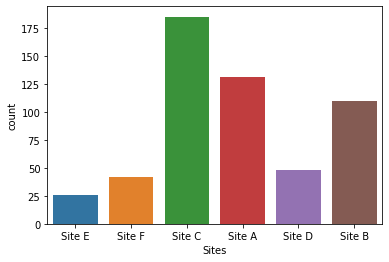

In [5]:
import seaborn as sns
ax = sns.countplot(x="Sites", data=df)

#### Statistics

In [6]:
cat_summary=df.select_dtypes(include=['O']).describe().T\
    .assign(missing_pct=df.apply(lambda x : (len(x)-x.count())/len(x)))

cat_summary.style.background_gradient(cmap='Greens')

,count,unique,top,freq,missing_pct
Sites,542,6,Site C,185,0.000000
Deliver Name,542,404,李*,10,0.000000
Feedback Tag,542,83,Delivery timeout,145,0.000000


### Numerical Variables-Distribution: Central Trend & Deviation Trend

In [7]:
df[['Pick Up Order Time','Arrival Time', 'Waiting Time', 
    'Deliver Time']].iplot(kind='histogram',subplots=True,bins=100,subplot_titles=True)

In [8]:
num_summary=(df.select_dtypes(include=['float64']).describe().T)\
    .assign(missing_pct=df.apply(lambda x: (len(x)-x.count())/len(x)),
           nunique = df.apply(lambda x: x.nunique()),
           pct_90=df.select_dtypes(include=['float64']).apply(lambda x: x.dropna().quantile(.90)),
           pct_95=df.select_dtypes(include=['float64']).apply(lambda x: x.dropna().quantile(.95)),
           pct_975=df.select_dtypes(include=['float64']).apply(lambda x: x.dropna().quantile(.975)))
num_summary
num_summary.style.background_gradient(cmap='Greens')

,count,mean,std,min,25%,50%,75%,max,missing_pct,nunique,pct_90,pct_95,pct_975
Pick Up Order Time,542.000000,4.141402,14.603411,0.000000,0.580000,1.170000,3.187500,259.420000,0.000000,259,7.748000,12.048500,23.913250
Arrival Time,542.000000,8.975203,8.654908,0.000000,2.782500,6.735000,12.895000,63.200000,0.000000,426,19.206000,24.957500,30.742500
Waiting Time,542.000000,4.301771,6.182401,0.000000,0.320000,1.650000,5.882500,56.180000,0.000000,308,12.118000,16.925000,22.560000
Deliver Time,542.000000,26.076310,15.947675,0.000000,13.940000,23.290000,35.902500,86.170000,0.000000,504,49.275000,58.409500,61.648750


## Data preprocessing
### Data cleaning

In [9]:
data=df.copy()
data.head()

,No,Sites,Deliver Name,Rating,Feedback Tag,Pick Up Order Time,Arrival Time,Waiting Time,Deliver Time
0,1,Site E,林*鹏,1,Delivery timeout,2.75,19.88,0.80,68.67
1,2,Site E,张*安,1,Others,0.07,6.87,1.93,6.30
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88
3,4,Site E,曾*平,1,Delivery timeout,68.32,6.33,0.17,18.93
4,5,Site E,黄*灶,1,Delivery timeout,15.80,12.90,7.23,10.18


#### 

In [10]:
num_summary

,count,mean,std,min,25%,50%,75%,max,missing_pct,nunique,pct_90,pct_95,pct_975
Pick Up Order Time,542.0,4.141402,14.603411,0.0,0.5800,1.170,3.1875,259.42,0.0,259,7.748,12.0485,23.91325
Arrival Time,542.0,8.975203,8.654908,0.0,2.7825,6.735,12.8950,63.20,0.0,426,19.206,24.9575,30.74250
Waiting Time,542.0,4.301771,6.182401,0.0,0.3200,1.650,5.8825,56.18,0.0,308,12.118,16.9250,22.56000
Deliver Time,542.0,26.076310,15.947675,0.0,13.9400,23.290,35.9025,86.17,0.0,504,49.275,58.4095,61.64875


In [11]:
# 选取元素 
num_summary.loc["Pick Up Order Time","pct_975"]

23.91325000000002

#### Outlier handling
-Duration variable <pct_975

In [12]:
data=data[(data["Pick Up Order Time"]<23.91325)&(data["Arrival Time"]<30.74250)&
          (data["Waiting Time"]<22.56000) &(data["Deliver Time"]<61.64875)]
print(data.shape)
data.head()

(487, 9)


,No,Sites,Deliver Name,Rating,Feedback Tag,Pick Up Order Time,Arrival Time,Waiting Time,Deliver Time
1,2,Site E,张*安,1,Others,0.07,6.87,1.93,6.30
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88
4,5,Site E,黄*灶,1,Delivery timeout,15.80,12.90,7.23,10.18
7,8,Site E,陈*贤,1,No notice on delivery,0.73,0.03,8.08,8.45
8,9,Site E,钟*林,1,No notice on delivery|Delivery timeout,1.35,8.92,3.65,37.27


In [13]:
data['N_Total Time']=data['Pick Up Order Time']+data['Arrival Time']+data['Waiting Time']+data['Deliver Time']
data.columns

Index(['No', 'Sites', 'Deliver Name', 'Rating', 'Feedback Tag',
       'Pick Up Order Time', 'Arrival Time', 'Waiting Time', 'Deliver Time',
       'N_Total Time'],
      dtype='object')

In [14]:
threshold=30 # Estimated arrival time 预计到达时间 
data['N_Overtime']=data['N_Total Time']-30
duration=data['N_Overtime'].value_counts().rename_axis('N_Overtime').reset_index(name='Number of order').sort_values(by='N_Overtime')
duration

,N_Overtime,Number of order
96,-28.90,1
230,-21.95,1
281,-20.24,1
222,-20.24,1
103,-20.02,1
...,...,...
60,50.12,1
408,52.17,1
410,52.47,1
58,57.24,1


##### Distribution of total duration & timeout duration

In [15]:
data[['N_Total Time','N_Overtime']].iplot(kind='histogram')

#### 

In [16]:
data.columns

Index(['No', 'Sites', 'Deliver Name', 'Rating', 'Feedback Tag',
       'Pick Up Order Time', 'Arrival Time', 'Waiting Time', 'Deliver Time',
       'N_Total Time', 'N_Overtime'],
      dtype='object')

In [17]:
bins = [-np.inf,-30,-20,-10,0,10,20,30,40,50,60,np.inf]
data['N_Overtime_group'] = pd.cut(data['N_Overtime'],bins)
data.head(3)



,No,Sites,Deliver Name,Rating,Feedback Tag,Pick Up Order Time,Arrival Time,Waiting Time,Deliver Time,N_Total Time,N_Overtime,N_Overtime_group
1,2,Site E,张*安,1,Others,0.07,6.87,1.93,6.30,15.17,-14.83,"(-20.0, -10.0]"
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88,64.73,34.73,"(30.0, 40.0]"
4,5,Site E,黄*灶,1,Delivery timeout,15.80,12.90,7.23,10.18,46.11,16.11,"(10.0, 20.0]"


#### Create New Variable

In [18]:
# 最超时环节 
dur_list=['Pick Up Order Time','Arrival Time', 'Waiting Time', 'Deliver Time']
data['N_The length of the most time-spending']=data[dur_list].max(axis=1) #列最大值 
data['N_The most spending time part']=data[dur_list].idxmax(axis=1) # 获取最大值表头索引
data.head(3)

,No,Sites,Deliver Name,Rating,Feedback Tag,Pick Up Order Time,Arrival Time,Waiting Time,Deliver Time,N_Total Time,N_Overtime,N_Overtime_group,N_The length of the most time-spending,N_The most spending time part
1,2,Site E,张*安,1,Others,0.07,6.87,1.93,6.30,15.17,-14.83,"(-20.0, -10.0]",6.87,Arrival Time
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88,64.73,34.73,"(30.0, 40.0]",51.88,Deliver Time
4,5,Site E,黄*灶,1,Delivery timeout,15.80,12.90,7.23,10.18,46.11,16.11,"(10.0, 20.0]",15.80,Pick Up Order Time


In [19]:
data.shape

(487, 14)

In [20]:
data['Customer Feedback Tag']=data['Feedback Tag'].apply(lambda x: x.split('|'))
data.head()

,No,Sites,Deliver Name,Rating,Feedback Tag,Pick Up Order Time,Arrival Time,Waiting Time,Deliver Time,N_Total Time,N_Overtime,N_Overtime_group,N_The length of the most time-spending,N_The most spending time part,Customer Feedback Tag
1,2,Site E,张*安,1,Others,0.07,6.87,1.93,6.30,15.17,-14.83,"(-20.0, -10.0]",6.87,Arrival Time,[Others]
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88,64.73,34.73,"(30.0, 40.0]",51.88,Deliver Time,"[Delivery timeout, Bad attitude]"
4,5,Site E,黄*灶,1,Delivery timeout,15.80,12.90,7.23,10.18,46.11,16.11,"(10.0, 20.0]",15.80,Pick Up Order Time,[Delivery timeout]
7,8,Site E,陈*贤,1,No notice on delivery,0.73,0.03,8.08,8.45,17.29,-12.71,"(-20.0, -10.0]",8.45,Deliver Time,[No notice on delivery]
8,9,Site E,钟*林,1,No notice on delivery|Delivery timeout,1.35,8.92,3.65,37.27,51.19,21.19,"(20.0, 30.0]",37.27,Deliver Time,"[No notice on delivery, Delivery timeout]"


In [21]:
data['Customer Feedback Tag']=data['Customer Feedback Tag'].apply(lambda x:"|".join(x)) # list转换为str

In [22]:
# 行-根据分隔符号转列 Transform each element of a list-like to a row, replicating index values.
data['Customer Feedback Tag']=data['Customer Feedback Tag'].map(lambda x:x.split("|"))
data_explode=data.explode('Customer Feedback Tag')
data_explode.to_excel(path+'data_explode.xlsx')
print(data_explode.shape)

(688, 15)


In [23]:
data_explode.head(3)

,No,Sites,Deliver Name,Rating,Feedback Tag,Pick Up Order Time,Arrival Time,Waiting Time,Deliver Time,N_Total Time,N_Overtime,N_Overtime_group,N_The length of the most time-spending,N_The most spending time part,Customer Feedback Tag
1,2,Site E,张*安,1,Others,0.07,6.87,1.93,6.30,15.17,-14.83,"(-20.0, -10.0]",6.87,Arrival Time,Others
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88,64.73,34.73,"(30.0, 40.0]",51.88,Deliver Time,Delivery timeout
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88,64.73,34.73,"(30.0, 40.0]",51.88,Deliver Time,Bad attitude


In [24]:
print(data_explode['Customer Feedback Tag'])

1                         Others
2               Delivery timeout
2                   Bad attitude
4               Delivery timeout
7          No notice on delivery
                 ...            
537             Delivery timeout
537                       Others
537                 Bad attitude
540    Not enough meals/Bad meal
541        No notice on delivery
Name: Customer Feedback Tag, Length: 688, dtype: object


In [25]:
# Deliver people 's negative dictionary
qscp_dict =    {"threat":"threat",
              "Irregular appearance":"Professional attitude",
              "Bad attitude":"Professional attitude",
              "Early delivery":"Illegal operation",
              "No notice on delivery":"Illegal operation",
              "Delivery timeout":"Delivery timeout",
              "Others":"Others",
                "Not enough meals/Bad meal":"Delivery process",
                "Wrong meal":"Delivery process"}


In [26]:
data_explode['Reviews Category']=data_explode['Customer Feedback Tag'].map(qscp_dict)
data_explode.to_excel(path+'data_explode.xlsx')


In [27]:
data_explode.columns

Index(['No', 'Sites', 'Deliver Name', 'Rating', 'Feedback Tag',
       'Pick Up Order Time', 'Arrival Time', 'Waiting Time', 'Deliver Time',
       'N_Total Time', 'N_Overtime', 'N_Overtime_group',
       'N_The length of the most time-spending',
       'N_The most spending time part', 'Customer Feedback Tag',
       'Reviews Category'],
      dtype='object')

# Analysis

## overview analysis

In [28]:
# 数据概况
print('差评数据概况：')
print('Sites total number：',data_explode['Sites'].unique().shape[0])
print('Deliver Person total',data_explode['Deliver Name'].unique().shape[0])
print('Total order of negative feedback：',data_explode['No'].unique().shape[0])
print('Total of Customer Feedback Tag：',data_explode['No'].shape[0])



差评数据概况：
Sites total number： 6
Deliver Person total 367
Total order of negative feedback： 487
Total of Customer Feedback Tag： 688


In [29]:
#将value_counts输出转换为dataframe
a =data_explode['Deliver Name'].value_counts().rename_axis('Deliver Name').reset_index(name='Number of negative feedback')
#print(a.head())
#print("-"*60)
a1=a["Number of negative feedback"].value_counts().rename_axis('Number of negative feedback').reset_index(name='Number of People').sort_values(by='Number of negative feedback')
a1['Cumulative number']=a1['Number of People'].cumsum()
a1['Proportion of people-%']=a1['Number of People']/a1['Number of People'].sum()*100
a1['Cumulative proportion of people-%']=a1['Cumulative number']/a1['Number of People'].sum()*100
a1

,Number of negative feedback,Number of People,Cumulative number,Proportion of people-%,Cumulative proportion of people-%
0,1,221,221,60.217984,60.217984
1,2,76,297,20.708447,80.926431
2,3,33,330,8.991826,89.918256
3,4,12,342,3.269755,93.188011
4,5,9,351,2.452316,95.640327
5,6,6,357,1.634877,97.275204
7,7,3,360,0.817439,98.092643
6,8,3,363,0.817439,98.910082
8,9,2,365,0.544959,99.455041
10,11,1,366,0.272480,99.727520


In [30]:
data_explode.head()

,No,Sites,Deliver Name,Rating,Feedback Tag,Pick Up Order Time,Arrival Time,Waiting Time,Deliver Time,N_Total Time,N_Overtime,N_Overtime_group,N_The length of the most time-spending,N_The most spending time part,Customer Feedback Tag,Reviews Category
1,2,Site E,张*安,1,Others,0.07,6.87,1.93,6.30,15.17,-14.83,"(-20.0, -10.0]",6.87,Arrival Time,Others,Others
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88,64.73,34.73,"(30.0, 40.0]",51.88,Deliver Time,Delivery timeout,Delivery timeout
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88,64.73,34.73,"(30.0, 40.0]",51.88,Deliver Time,Bad attitude,Professional attitude
4,5,Site E,黄*灶,1,Delivery timeout,15.80,12.90,7.23,10.18,46.11,16.11,"(10.0, 20.0]",15.80,Pick Up Order Time,Delivery timeout,Delivery timeout
7,8,Site E,陈*贤,1,No notice on delivery,0.73,0.03,8.08,8.45,17.29,-12.71,"(-20.0, -10.0]",8.45,Deliver Time,No notice on delivery,Illegal operation


In [31]:
grouped_data = data_explode.groupby(['Sites','Reviews Category','Customer Feedback Tag'],as_index=False)

c=grouped_data.agg({"Rating":sum})

c.columns = ['Sites','Reviews Category','Customer Feedback Tag','Number of negative reviews']
c

,Sites,Reviews Category,Customer Feedback Tag,Number of negative reviews
0,Site A,Delivery process,Not enough meals/Bad meal,33
1,Site A,Delivery process,Wrong meal,4
2,Site A,Delivery timeout,Delivery timeout,42
3,Site A,Illegal operation,Early delivery,16
4,Site A,Illegal operation,No notice on delivery,6
5,Site A,Others,Others,24
6,Site A,Professional attitude,Bad attitude,41
7,Site A,Professional attitude,Irregular appearance,16
8,Site B,Delivery process,Not enough meals/Bad meal,14
9,Site B,Delivery process,Wrong meal,5


In [32]:
c.columns

Index(['Sites', 'Reviews Category', 'Customer Feedback Tag',
       'Number of negative reviews'],
      dtype='object')

In [33]:
data_explode.iplot(kind='pie',labels='Reviews Category',values='Rating',title='Reviews Category')

In [34]:
fig = px.bar(c, x="Customer Feedback Tag", y="Number of negative reviews", color="Reviews Category", title="Negative review type distribution")
fig.show()

In [35]:
crosstab1=pd.crosstab(index=data_explode['Sites'],
                      columns=data_explode['Reviews Category'],
                      values=data_explode['Rating'],
                      aggfunc=np.size #np.unique 
                     # ,margins=True
           ).round(0).fillna(0).astype('int')
crosstab11=crosstab1.apply(lambda x: x/crosstab1.sum(axis=1))*100
crosstab11.style.background_gradient(cmap='Greens')

Reviews Category,Delivery process,Delivery timeout,Illegal operation,Others,Professional attitude
Sites,,,,,
Site A,20.329670,23.076923,12.087912,13.186813,31.318681
Site B,14.503817,30.534351,9.160305,19.847328,25.954198
Site C,19.642857,28.571429,12.500000,15.625000,23.660714
Site D,18.644068,30.508475,13.559322,18.644068,18.644068
Site E,18.181818,24.242424,33.333333,6.060606,18.181818
Site F,20.833333,35.416667,4.166667,16.666667,22.916667


In [36]:
crosstab11.iplot(kind='bar',barmode='stack',title="aa")

In [37]:
data_explode.columns


Index(['No', 'Sites', 'Deliver Name', 'Rating', 'Feedback Tag',
       'Pick Up Order Time', 'Arrival Time', 'Waiting Time', 'Deliver Time',
       'N_Total Time', 'N_Overtime', 'N_Overtime_group',
       'N_The length of the most time-spending',
       'N_The most spending time part', 'Customer Feedback Tag',
       'Reviews Category'],
      dtype='object')

In [38]:
crosstab2=pd.crosstab(index=data_explode['Sites'],
                      columns=data_explode['Reviews Category'],
                      values=data_explode['Deliver Name'],
                      aggfunc='nunique' #dataframe去重
                     # , margins=True
           ).round(0).fillna(0).astype('int')
crosstab2.style.background_gradient(cmap='Greens')

Reviews Category,Delivery process,Delivery timeout,Illegal operation,Others,Professional attitude
Sites,,,,,
Site A,35,39,19,22,36
Site B,17,40,11,26,27
Site C,40,56,24,32,41
Site D,10,18,7,11,10
Site E,6,8,9,2,6
Site F,10,17,2,7,9


In [39]:
crosstab22=crosstab2.apply(lambda x: x/crosstab2.sum(axis=1))*100

In [40]:
crosstab22.iplot(kind='bar',barmode='stack',title="aa")

### Analysis of the timeout situation of each site

#### Timeout : C> A> B

In [41]:

sub=data_explode[data_explode['Reviews Category']=='Delivery timeout']
sub.head(5)

,No,Sites,Deliver Name,Rating,Feedback Tag,Pick Up Order Time,Arrival Time,Waiting Time,Deliver Time,N_Total Time,N_Overtime,N_Overtime_group,N_The length of the most time-spending,N_The most spending time part,Customer Feedback Tag,Reviews Category
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88,64.73,34.73,"(30.0, 40.0]",51.88,Deliver Time,Delivery timeout,Delivery timeout
4,5,Site E,黄*灶,1,Delivery timeout,15.80,12.90,7.23,10.18,46.11,16.11,"(10.0, 20.0]",15.80,Pick Up Order Time,Delivery timeout,Delivery timeout
8,9,Site E,钟*林,1,No notice on delivery|Delivery timeout,1.35,8.92,3.65,37.27,51.19,21.19,"(20.0, 30.0]",37.27,Deliver Time,Delivery timeout,Delivery timeout
11,12,Site E,王*杰,1,Delivery timeout|Not enough meals/Bad meal,9.90,12.15,1.62,21.67,45.34,15.34,"(10.0, 20.0]",21.67,Deliver Time,Delivery timeout,Delivery timeout
14,15,Site E,袁*,1,Delivery timeout|Bad attitude|No notice on del...,4.07,18.53,0.12,12.27,34.99,4.99,"(0.0, 10.0]",18.53,Arrival Time,Delivery timeout,Delivery timeout


In [43]:
fig = px.histogram(sub, x="N_Total Time", color="Sites",marginal="box")
fig.show()

#### Timeout main part

In [44]:
data_explode.head(3)

,No,Sites,Deliver Name,Rating,Feedback Tag,Pick Up Order Time,Arrival Time,Waiting Time,Deliver Time,N_Total Time,N_Overtime,N_Overtime_group,N_The length of the most time-spending,N_The most spending time part,Customer Feedback Tag,Reviews Category
1,2,Site E,张*安,1,Others,0.07,6.87,1.93,6.30,15.17,-14.83,"(-20.0, -10.0]",6.87,Arrival Time,Others,Others
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88,64.73,34.73,"(30.0, 40.0]",51.88,Deliver Time,Delivery timeout,Delivery timeout
2,3,Site E,林*健,1,Delivery timeout|Bad attitude,1.45,11.35,0.05,51.88,64.73,34.73,"(30.0, 40.0]",51.88,Deliver Time,Bad attitude,Professional attitude


In [47]:
# Distribution of negative reviews on each site
sub2=pd.crosstab(index=data_explode['Sites'],columns=data_explode['N_The most spending time part'],
                 values=data_explode['Rating'],
                 aggfunc='sum').round(0).fillna(0).astype('int')

In [48]:
#### Proportion of timeout distribution
sub22=sub2.apply(lambda x: x/sub2.sum(axis=1))*100
sub22.style.background_gradient(cmap='Greens')
sub22

N_The most spending time part,Arrival Time,Deliver Time,Pick Up Order Time,Waiting Time
Sites,,,,
Site A,17.837838,77.297297,1.081081,3.783784
Site B,8.333333,84.090909,0.000000,7.575758
Site C,17.543860,78.070175,1.315789,3.070175
Site D,24.193548,70.967742,1.612903,3.225806
Site E,18.181818,75.757576,6.060606,0.000000
Site F,8.333333,89.583333,0.000000,2.083333


In [49]:
sub22.iplot(kind='bar',barmode='stack',title="aa")

## Deliver people  Analysis 

In [50]:
sub3=pd.crosstab(index=data_explode['Deliver Name'],columns=data_explode['Reviews Category'],
                 values=data_explode['Deliver Name'],
                 aggfunc='nunique'
                 #,margins=True
                ).round(0).fillna(0).astype('int')
sub3.reset_index()
sub3

Reviews Category,Delivery process,Delivery timeout,Illegal operation,Others,Professional attitude
Deliver Name,,,,,
丁*东,1,1,1,1,0
万*云,0,0,0,0,1
丘*燕,1,0,0,0,0
严*炜,1,0,0,0,1
严*生,0,1,0,0,0
...,...,...,...,...,...
黄*雄,0,0,0,0,1
黄*龙,0,0,0,0,1
黎*,1,0,0,0,0


# Action strategy

1.Based on negative reviews categories of deliver people to have some training or punishment. 
2.Based on negative reviews categories of sites to have update about management.